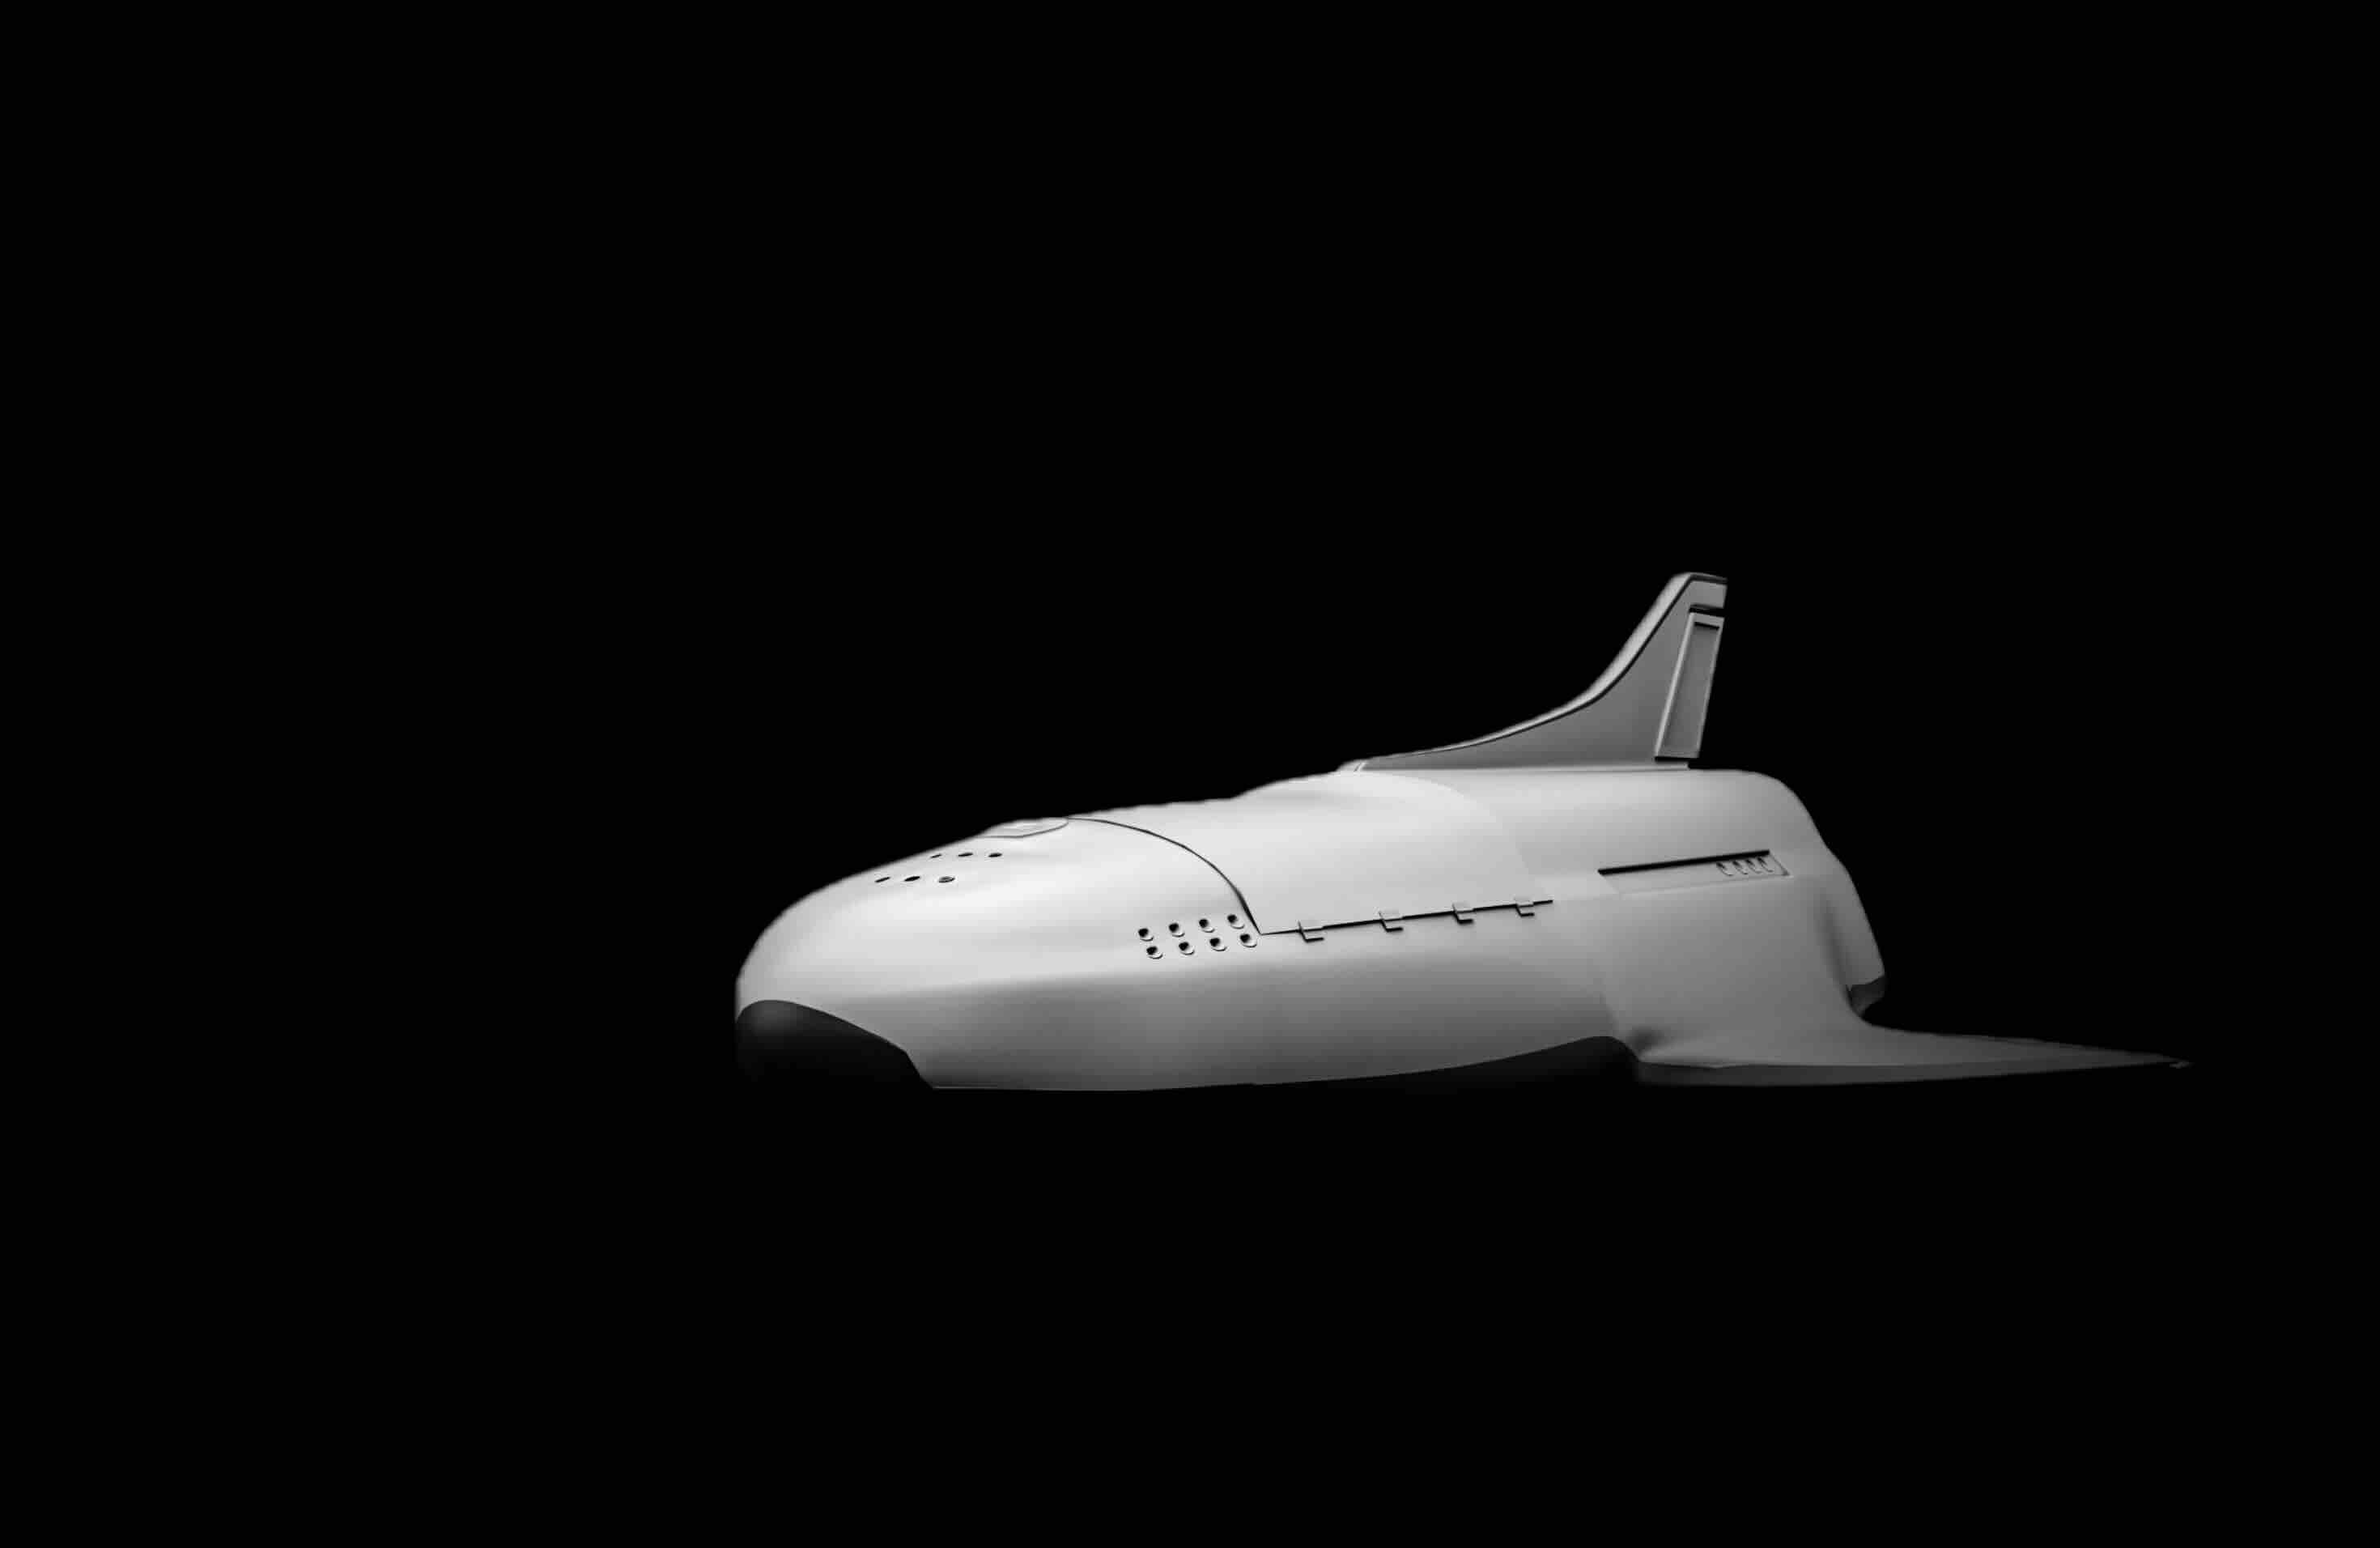

--- 
### SUMMARY

1. [Read the Data](#1)
2. [Exploratory Data Analysis](#2)
3. [Feature Engineering](#3)
4. [Data Preprocessing](#4)
5. [Model Selection](#5)
6. [Submission of the Results](#6)
---

# 1. Read the Data
<a id="1"></a>

In [ ]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns  

from sklearn.preprocessing import LabelEncoder,MinMaxScaler,StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split,GridSearchCV,validation_curve
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier,AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
from sklearn.metrics import confusion_matrix

from time import time

from xgboost import XGBClassifier

from warnings import simplefilter
simplefilter("ignore")

In [ ]:
df_in   = pd.read_csv('/kaggle/input/spaceship-titanic/train.csv')
df_test = pd.read_csv('/kaggle/input/spaceship-titanic/test.csv')

df_in.head()

There are 13 independent variables and 1 target variable ('Transported').

* PassengerId
* HomePlanet
* CryoSleep
* Cabin
* Destination
* Age
* VIP
* RoomService
* FoodCourt
* ShoppingMall
* Spa
* VRDeck
* Name

In [ ]:
print(f"The 'input' dataset has {df_in.shape[0]} rows and {df_in.shape[1]} columns.")

In [ ]:
print(f"The test dataset has {df_test.shape[0]} rows and {df_test.shape[1]} columns.")

**Null and duplicate values**

In [ ]:
print(f"There are {df_in.isnull().sum().sum()} null values in the 'input' dataset.")

I am plotting a histogram of them.

In [ ]:
def plot_nulls(data,title,x_axis_label,y_axis_label):
    
    # number of nulls for each column
    data_nulls = (data.apply(lambda x:x.isnull().value_counts()).T[True]/len(data)*100).reset_index(name='count')

    plt.figure(figsize=(12,6))
    sns.barplot(data_nulls,x="index",y="count")
    
    plt.title(title,fontsize=20)
    plt.xlabel(x_axis_label,fontsize=15)
    plt.xticks(rotation=45,fontsize=12)
    plt.ylabel(y_axis_label,fontsize=15)
    
    plt.tight_layout()
    plt.show()
    
plot_nulls(df_in,"Null Values in 'Input' Data",'features','% of null values')  

In [ ]:
plot_nulls(df_test,"Null Values in Test Data",'features','% of null values')  

In [ ]:
print(f'Duplicated rows: input data ({df_in.duplicated().sum()}), test data ({df_test.duplicated().sum()})')

There are no duplicate values.

**Check for Target Class Imbalance**

It is important to check whether the target classes are balanced or not.

In [ ]:
target_class = df_in.groupby('Transported')['Transported'].count().reset_index(name='count').sort_values(['count'], ascending= False)

target_class

In [ ]:
val = df_in['Transported'].value_counts()

plt.figure(figsize=(8,4))
plt.pie(val,labels=['transported','not transported'],autopct="%1.1f%%",shadow=True,explode=(0.03,0.03))
plt.title('Distribution of Transported',fontsize=20)
plt.tight_layout()

The target classes are perfectly balanced.

# 2. Exploratory Data Analysis
<a id="2"></a>

## 2.1 Transported Rate vs Home Planet & Cryo Sleep/Awake & Regular/VIP Passenger & Age

I am plotting the home planet distribution of the passengers and also the transported rate as a function of the home planet.

In [ ]:
def label_function(val):
    return f'{val:.0f}%'

transported_rate = {True:'transported',False:'not transported'}
df_in['transported_rate'] = df_in['Transported'].map(transported_rate)

val1 = df_in['HomePlanet'].value_counts()
val2 = df_in[df_in['HomePlanet'] == 'Earth']['transported_rate'].value_counts()
val3 = df_in[df_in['HomePlanet'] == 'Europa']['transported_rate'].value_counts()
val4 = df_in[df_in['HomePlanet'] == 'Mars']['transported_rate'].value_counts()

fig,(ax1,ax2,ax3,ax4) = plt.subplots(ncols=4,figsize=(12,4))

val1.plot(kind='pie',label="",autopct=label_function,textprops={'fontsize':10},explode=(0.01,0.01,0.01),ax=ax1)
ax1.set_title('Home Planet',size=15)
val2.plot(kind='pie',label="",autopct=label_function,textprops={'fontsize':10},explode=(0.01,0.01),ax=ax2)
ax2.set_title('Transported Rate: Earth',size=15)
val3.plot(kind='pie',label="",autopct=label_function,textprops={'fontsize':10},explode=(0.01,0.01),ax=ax3)
ax3.set_title('Transported Rate: Europa',size=15)
val4.plot(kind='pie',label="",autopct=label_function,textprops={'fontsize':10},explode=(0.01,0.01),ax=ax4)
ax4.set_title('Transported Rate: Mars',size=15)

fig.suptitle("Transported Rate vs Home Planet",fontsize=25) 

plt.tight_layout() 

Then, I am plotting the transported rate of the passengers as a function of their cryo sleep state (passangers either in cryo sleep or awake).

In [ ]:
val1 = df_in['CryoSleep'].value_counts()
val2 = df_in[df_in['CryoSleep'] == False]['transported_rate'].value_counts()
val3 = df_in[df_in['CryoSleep'] == True]['transported_rate'].value_counts()

fig,(ax1,ax2,ax3) = plt.subplots(ncols=3,figsize=(12,5))

val1.plot(kind='pie',label="",autopct=label_function,textprops={'fontsize':10},explode=(0.01,0.01),ax=ax1)
ax1.set_title('In Cryo Sleep?',size=15)
val2.plot(kind='pie',label="",autopct=label_function,textprops={'fontsize':10},explode=(0.01,0.01),ax=ax2)
ax2.set_title('Transported Rate: Awake',size=15)
val3.plot(kind='pie',label="",autopct=label_function,textprops={'fontsize':10},explode=(0.01,0.01),ax=ax3)
ax3.set_title('Transported Rate: in Cryo Sleep',size=15)

fig.suptitle("Transported Rate vs Cryo Sleep/Awake",fontsize=25) 

plt.tight_layout() 
plt.show()

I am also having a look at the stats concerning the VIP passengers.

In [ ]:
val1 = df_in['VIP'].value_counts()
val2 = df_in[df_in['VIP'] == True].groupby('CryoSleep').size()
val3 = df_in[df_in['VIP'] == False].groupby('CryoSleep').size()

fig,(ax1,ax2,ax3) = plt.subplots(ncols=3,figsize=(12,5))

val1.plot(kind='pie',label="",autopct=label_function,textprops={'fontsize':10},explode=(0.01,0.01),ax=ax1)
val2.plot(kind='pie',label="",autopct=label_function,textprops={'fontsize':10},explode=(0.01,0.01),ax=ax2)
val3.plot(kind='pie',label="",autopct=label_function,textprops={'fontsize':10},explode=(0.01,0.01),ax=ax3)

ax1.set_title('Is VIP?',size=15)
ax2.set_title('In Cryo Sleep? (VIP)',size=15)
ax3.set_title('In Cryo Cleep? (Regular Passenger)',size=15)

plt.suptitle('VIP vs Cryo Sleep',size=25)

plt.tight_layout()
plt.show()

In [ ]:
val1 = df_in['VIP'].value_counts()
val2 = df_in[df_in['VIP'] == False]['transported_rate'].value_counts()
val3 = df_in[df_in['VIP'] == True]['transported_rate'].value_counts()

fig,(ax1,ax2,ax3) = plt.subplots(ncols=3,figsize=(12,5))

val1.plot(kind='pie',label="",autopct=label_function,textprops={'fontsize':10},explode=(0.01,0.01),ax=ax1)
ax1.set_title('Is VIP?',size=15)
val2.plot(kind='pie',label="",autopct=label_function,textprops={'fontsize':10},explode=(0.01,0.01),ax=ax2)
ax2.set_title('Transported Rate: Regular Passenger',size=15)
val3.plot(kind='pie',label="",autopct=label_function,textprops={'fontsize':10},explode=(0.01,0.01),ax=ax3)
ax3.set_title('Transported Rate: VIP Passenger',size=15)

fig.suptitle("Transported Rate vs Regular/VIP Passengers",fontsize=25) 

plt.tight_layout() 
plt.show()

And finally I am checking the transported rate as a function of age.

In [ ]:
fig,(ax1,ax2) = plt.subplots(ncols=2,figsize=(14,6))

file5A = df_in.groupby('Age')['Age'].count().reset_index(name='count')#.sort_values(['count'],ascending= False)
file5B = df_in[df_in['Transported'] == True].groupby('Age')['Age'].count().reset_index(name='count')#.sort_values(['count'],ascending= False)

xa1=file5A['Age']
ya1=file5A['count']
xa2=file5B['Age']
ya2=file5B['count']

ax1.bar(xa1,ya1,color='red',alpha=0.3,linewidth=3)
ax1.bar(xa2,ya2,color='blue',alpha=0.5,linewidth=3)
ax1.set_title('Transported Rate vs Age',size=18)
ax1.set_xlabel('age',size=15)
ax1.set_ylabel('count',size=15)
ax1.legend(labels={"total","transported"},loc="upper right")

ax2 = sns.histplot(data=df_in,x='Age',multiple='stack',hue='Transported',element='step',ax=ax2)
ax2.set_title('Transported Rate vs Age (Stacked)',fontsize=18)

fig.suptitle("Transported Rate vs Age",fontsize=25) 

plt.tight_layout() 
plt.show()

In [ ]:
df_in.drop('transported_rate',axis=1,inplace=True)

## 2.2 Destination vs Home Planet & Regular/VIP Passenger

It could be useful to know the passengers' destination as a function of their home planet and their 'status' (regular passengers or VIP).

In [ ]:
val1 = df_in['Destination'].value_counts()
val2 = df_in[df_in['HomePlanet'] == 'Earth']['Destination'].value_counts()
val3 = df_in[df_in['HomePlanet'] == 'Europa']['Destination'].value_counts()
val4 = df_in[df_in['HomePlanet'] == 'Mars']['Destination'].value_counts()

fig,(ax1,ax2,ax3,ax4) = plt.subplots(ncols=4,figsize=(12,3))

val1.plot(kind='pie',label="",autopct=label_function,textprops={'fontsize':10},explode=(0.01,0.01,0.01),ax=ax1)
ax1.set_title('Destination',size=15)
val2.plot(kind='pie',label="",autopct=label_function,textprops={'fontsize':10},explode=(0.01,0.01,0.01),ax=ax2)
ax2.set_title('Home Planet: Earth',size=15)
val3.plot(kind='pie',label="",autopct=label_function,textprops={'fontsize':10},explode=(0.01,0.01,0.01),ax=ax3)
ax3.set_title('Home Planet: Europa',size=15)
val4.plot(kind='pie',label="",autopct=label_function,textprops={'fontsize':10},explode=(0.01,0.01,0.01),ax=ax4)
ax4.set_title('Home Planet: Mars',size=15)

fig.suptitle("Home Planet vs Destination",fontsize=25) 

plt.tight_layout() 
plt.show()

In [ ]:
val1 = df_in[df_in['VIP'] == True]['HomePlanet'].value_counts()
val2 = df_in[df_in['VIP'] == False]['HomePlanet'].value_counts()
val3 = df_in[df_in['VIP'] == True]['Destination'].value_counts()
val4 = df_in[df_in['VIP'] == False]['Destination'].value_counts()

fig,(ax1,ax2,ax3,ax4) = plt.subplots(ncols=4,figsize=(12,3))

val1.plot(kind='pie',label="",autopct=label_function,textprops={'fontsize':10},explode=(0.01,0.01),ax=ax1)
ax1.set_title('Home Planet: VIPs',size=15)
val2.plot(kind='pie',label="",autopct=label_function,textprops={'fontsize':10},explode=(0.01,0.01,0.01),ax=ax2)
ax2.set_title('Home Planet: Regular Passengers',size=15)
val3.plot(kind='pie',label="",autopct=label_function,textprops={'fontsize':10},explode=(0.01,0.01,0.01),ax=ax3)
ax3.set_title('Destination: VIPs',size=15)
val4.plot(kind='pie',label="",autopct=label_function,textprops={'fontsize':10},explode=(0.01,0.01,0.01),ax=ax4)
ax4.set_title('Destination: Regular Passengers',size=15)

fig.suptitle("VIP/Regular Passengers vs Destination",fontsize=25) 

plt.tight_layout() 
plt.show()

## 2.3 Services (RoomService, FoodCourt, ShoppingMall, Spa and VRDeck)

Then, I am having a look at the distributions of services provided by the spaceship, that include room service, spa, and so on.

In [ ]:
services = ["RoomService","FoodCourt","ShoppingMall","Spa","VRDeck"]

def plot_hist(variable):
    
    fig,(ax1,ax2) = plt.subplots(ncols=2,figsize=(15,5)) 
    
    ax1.hist(df_in[variable],bins=50)
    ax1.set(xlim=(0,5000))
    ax1.set_xlabel(variable,size=15)
    ax1.set_ylabel("Frequency",size=15)
    ax1.set_title("Histogram distribution of {}".format(variable),fontsize=18)
    
    ax2 = df_in[variable].plot.box(fontsize=15)
    ax2.set(ylim=(-100,600))
    ax2.set_title("Box plot of {}".format(variable),fontsize=18)
    plt.show()

for n in services:
    plot_hist(n)

On the left size, the plots show that the 'Service' variables are not normal distributed, their values being shifted towards 0. It means that the majority of passengers made little use of room service, shopping ... (or better they spent little). On the right hand, the box plots show the presence of a large number of outliers (the passengers who spent enough money on services).

Below, I am plotting the distribution of Services vs Age Group.

In [ ]:
# Define AgeClass column
age_bins = [0,10,20,30,40,50,60,70,80]
age_labels = [f"{i}-{i+9}" for i in range(0,80,10)]
df_in['AgeClass'] = pd.cut(df_in['Age'],bins=age_bins,labels=age_labels,right=False)

RoomService_by_age = df_in.groupby('AgeClass')['RoomService'].sum().reset_index()
FoodCourt_by_age = df_in.groupby('AgeClass')['FoodCourt'].sum().reset_index()
ShoppingMall_by_age = df_in.groupby('AgeClass')['ShoppingMall'].sum().reset_index()
Spa_by_age = df_in.groupby('AgeClass')['Spa'].sum().reset_index()
VRDeck_by_age = df_in.groupby('AgeClass')['VRDeck'].sum().reset_index()

sns.set(style="whitegrid",font_scale=0.8)

fig = plt.figure(figsize=(10, 7))
(topfig,bottomfig) = fig.subfigures(2, 1)

topfig.subplots_adjust(left=.1,right=.9,wspace=.4,hspace=.4)
fig,axes = plt.subplots(1,3,figsize=(15,5),sharey=True)
sns.barplot(ax=axes[0],x='AgeClass',y='RoomService',data=RoomService_by_age)
sns.barplot(ax=axes[1],x='AgeClass',y='FoodCourt',data=FoodCourt_by_age)
sns.barplot(ax=axes[2],x='AgeClass',y='ShoppingMall',data=ShoppingMall_by_age)

fig.suptitle("Services vs Age Group",fontsize=20) 

bottomfig.subplots_adjust(left=.1,right=.9,wspace=.4,hspace=.4)
fig,axes = plt.subplots(1,2,figsize=(15,5),sharey=True)
sns.barplot(ax=axes[0],x='AgeClass',y='Spa',data=Spa_by_age)
sns.barplot(ax=axes[1],x='AgeClass',y='VRDeck',data=VRDeck_by_age)

plt.tight_layout();

One can notice that the highest amount of services is used by the passengers in the 20-29 and 30-39 age groups.

In [ ]:
df_in.drop('AgeClass',axis=1,inplace=True)

# 3. Feature Engineering
<a id="3"></a>

## 3.1 How to Deal with Null Values

I am doing this in order to make the cleaning and preprocessing procedures easier and faster.

In [ ]:
# Save the target variable of the train dataset
target = df_in["Transported"]

# Save test PassengerId in test_id
test_id = df_test["PassengerId"]

# Drop the 'Transported' variable from the train dataset
df_in2 = df_in.drop(["Transported"],axis=1)

# Merge the train and 'final' (or 'submission') datasets 
data = pd.concat([df_in2,df_test],axis=0).reset_index(drop=True)

print(data.shape)

The merged dataframe has 12970 rows and 13 columns. The amount of missing entries in their respective columns is given below.

In [ ]:
plot_nulls(data,"Null Values in the Data",'features','% of null values')  

I am checking what is the number of passengers that have at least a missing value in their features.

In [ ]:
total_number_passengers = len(data)

null_data = data.isna().sum(axis=1).reset_index(name='nulls_per_passenger').groupby('nulls_per_passenger')['nulls_per_passenger'].count().reset_index(name='count')
null_data['percentage'] = null_data['count'] / total_number_passengers * 100

null_data['nulls_per_passenger'] = null_data['nulls_per_passenger'].replace({0:'no nulls',1:'one null',2:'two nulls',3:'three nulls'})

null_data.head()

In [ ]:
fig,(ax1,ax2) = plt.subplots(ncols=2,figsize=(12,6))

ax1 = sns.barplot(data=null_data,x='nulls_per_passenger',y='count',ax=ax1)
ax1.set_title('Total Number',size=20)

ax2 = sns.barplot(data=null_data,x='nulls_per_passenger',y='percentage',ax=ax2)
ax2.set_title('Fraction of the Total',size=20)

plt.suptitle('Missing Values per Passenger',size=25)

plt.tight_layout()

**These plots show that more than 20% of the passengers have at least a null value in their features. This is a large fraction of the total.** <br>This is why the procedure for filling the nulls should be carried out with care.

I will try to fill the null values by using the other features. In case I cannot impute them all, I will fill those of the categorical variables with their mode and those of the numerical variables with their median. 

## 3.3 Cabin Deck/Side Features (New Features)

The 'Cabin' number is split into 2 new features: 'CabinDeck' and 'CabinSide'. The null entries are filled with their column mode.

In [ ]:
# Fill null cabin numbers
data['Cabin'] = data['Cabin'].fillna("None/None/None")

# Define a function which splits the 'Cabin' name into 3 parts
def split_cabin(name):
    return pd.Series(name.split("/",2))

# Apply the split_cabin function to the "Name" column using apply()
data[['CabinDeck','CabinNumber','CabinSide']] = data['Cabin'].apply(split_cabin)
 
# Dropping the old "Cabin" column
data.drop(columns=["Cabin"],inplace=True)

In [ ]:
fig,(ax1,ax2) = plt.subplots(ncols=2,figsize=(13,5))

dist_deck = data.groupby(['CabinDeck','HomePlanet'])['CabinDeck'].count().reset_index(name='Count').sort_values(['Count'],ascending=False) 
dist_side = data.groupby(['CabinSide','HomePlanet'])['CabinSide'].count().reset_index(name='Count').sort_values(['Count'],ascending=False)

ax1 = sns.barplot(data=dist_deck,x='CabinDeck',y='Count',hue='HomePlanet',dodge=False,alpha=0.5,ax=ax1)
ax1.set_title('Cabin Deck vs Home Planet',fontsize=20)

ax2 = sns.barplot(data=dist_side,x='CabinSide',y='Count',hue='HomePlanet',dodge=False,alpha=0.5,ax=ax2)
ax2.set_title('Cabin Side vs Home Planet',fontsize=20)

plt.tight_layout()
plt.show()

The CabinDeck feature has a strong correlation with the HomePlanet. People from deck G only come from the Earth, those from decks B, C and A only come from Europa.

In [ ]:
fig,(ax1,ax2) = plt.subplots(ncols=2,figsize=(13,5))

dist_deck2 = data.groupby(['CabinDeck','Destination'])['CabinDeck'].count().reset_index(name='Count').sort_values(['Count'],ascending=False) 
dist_side2 = data.groupby(['CabinSide','Destination'])['CabinSide'].count().reset_index(name='Count').sort_values(['Count'],ascending=False)

ax1 = sns.barplot(data=dist_deck2,x='CabinDeck',y='Count',hue='Destination',dodge=False,alpha=0.5,ax=ax1)
ax1.set_title('Cabin Deck vs Destination',fontsize=20)

ax2 = sns.barplot(data=dist_side2,x='CabinSide',y='Count',hue='Destination',dodge=False,alpha=0.5,ax=ax2)
ax2.set_title('Cabin Side vs Destination',fontsize=20)

plt.tight_layout()
plt.show()

**Filling Null Values**

I am filling the null values of 'HomePlanet' by using the previous findings.

In [ ]:
# Null 'HomePlanet' values before imputation
nulls_home_planet_before = data['HomePlanet'].isna().sum()

# Cabin decks A, B, C or T from Europa
data.loc[(data['HomePlanet'].isna()) & (data['CabinDeck'].isin(['A','B','C','T'])), 'HomePlanet'] = 'Europa'

# Cabin deck G from Earth
data.loc[(data['HomePlanet'].isna()) & (data['CabinDeck'] == 'G'), 'HomePlanet'] = 'Earth'

# Null 'HomePlanet' values after imputation
nulls_home_planet_after = data['HomePlanet'].isna().sum()

print(f'Number of nulls in HomePlanet column: before ({nulls_home_planet_before}) and after ({nulls_home_planet_after}) imputation.')

After filling the null values in the 'HomePlanet' column, I will substitute the 'None' values in the 'CabinDeck', 'CabinNumber' and 'CabinSide' with their columns' modes.

In [ ]:
data.loc[data['CabinDeck'] == 'None', 'CabinDeck'] = data['CabinDeck'].mode()[0]

data.loc[data['CabinNumber'] == 'None', 'CabinNumber'] = data.loc[data['CabinNumber'] != 'None']['CabinNumber'].mode()[0]

data.loc[data['CabinSide'] == 'None', 'CabinSide'] = data['CabinSide'].mode()[0]

# Converting 'CabinNumber' from string to int
data['CabinNumber'] = data['CabinNumber'].astype(int)

## 3.4 First Name and Surname (NEW)

I am splitting the passengers' names into first names and surnames.

In [ ]:
data['Name'] = data['Name'].fillna("None None")

# define a function to split a name into first and last names
def split_name(name):
    return pd.Series(name.split(" ", 1))

# Apply the split_name function to the "Name" column using apply()
data[['First Name','Surname']] = data['Name'].apply(split_name)
 
# Dropping old "Name" column
data.drop(columns=["Name"],inplace=True)

data.head()

I am curious to see if Earth, Europa and Mars have peculiar names and/or surnames. This could be used e.g. to fill null 'HomePlanet' values.

In [ ]:
data_earth  = data[data['HomePlanet'] == 'Earth']
data_europa = data[data['HomePlanet'] == 'Europa']
data_mars   = data[data['HomePlanet'] == 'Mars']

print(data['Surname'].nunique(),data_earth['Surname'].nunique()+data_europa['Surname'].nunique()+data_mars['Surname'].nunique())

In [ ]:
surnames_earth = pd.unique(data_earth['Surname'].values.ravel()).tolist()
surnames_earth.remove('None')

surnames_europa = pd.unique(data_europa['Surname'].values.ravel()).tolist()
surnames_europa.remove('None')

surnames_mars = pd.unique(data_mars['Surname'].values.ravel()).tolist()
surnames_mars.remove('None')

I am checking if the surname lists overlap or not.

In [ ]:
# Surname overlaps
def lists_overlap(a, b):
    for i in a:
        if i in b:
            return True
        return False

# Overlaps
if not lists_overlap(surnames_earth,surnames_europa): print('No Earth-Europa overlap')
if not lists_overlap(surnames_mars,surnames_europa): print('No Mars-Europa overlap')
if not lists_overlap(surnames_mars,surnames_earth): print('No Mars-Earth overlap')    

The surname lists do not overlap. This means that the Earth, Europa and Mars have their peculiar surnames.

In [ ]:
# Null 'HomePlanet' values before imputation
nulls_home_planet_before = data['HomePlanet'].isna().sum()

# Surname from Earth
data.loc[(data['HomePlanet'].isna()) & (data['Surname'].isin(surnames_earth)), 'HomePlanet'] = 'Earth'
# Surname from Europa
data.loc[(data['HomePlanet'].isna()) & (data['Surname'].isin(surnames_europa)), 'HomePlanet'] = 'Europa'
# Surname from Mars
data.loc[(data['HomePlanet'].isna()) & (data['Surname'].isin(surnames_mars)), 'HomePlanet'] = 'Mars'

# Null 'HomePlanet' values after imputation
nulls_home_planet_after = data['HomePlanet'].isna().sum()

print(f'Number of nulls in HomePlanet column: before ({nulls_home_planet_before}) and after ({nulls_home_planet_after}) imputation.')

There are only 13 null values left in 'HomePlanet' after imputation. I will impute them with their column's mode.

In [ ]:
data['HomePlanet'].fillna(data['HomePlanet'].value_counts().index[0],inplace=True)

data['HomePlanet'].isna().sum()

I will drop the column 'First Name'. Later, I will try to fill the 'None' values in 'Surname' based on patterns found in other columns.

In [ ]:
data.drop('First Name',axis=1,inplace=True)

## 3.5 Service Features (NEW)

The spaceship, like any cruise ship, provides services to their guests. They can be gathered into two main categories: Standard (FoodCourt and ShoppingMall) and Superior (RoomService, Spa and VRDeck). Three new features are created (including the total spending, 'Services') and five old features are dropped.

In [ ]:
data['StandardServices'] = data['FoodCourt'] + data['ShoppingMall'] 
data['SuperiorServices'] = data['RoomService'] + data['Spa'] + data['VRDeck']
data['Services'] = data['StandardServices'] + data['SuperiorServices']

data.drop(columns=["FoodCourt","ShoppingMall","RoomService","Spa","VRDeck"],axis=1,inplace=True)

data.head()

In [ ]:
standard_planet = data.groupby(['HomePlanet'])['StandardServices'].mean().reset_index(name='Mean').sort_values(['Mean'],ascending=False) 
superior_planet = data.groupby(['HomePlanet'])['SuperiorServices'].mean().reset_index(name='Mean').sort_values(['Mean'],ascending=False) 
service_planet  = data.groupby(['HomePlanet'])['Services'].mean().reset_index(name='Mean').sort_values(['Mean'],ascending=False) 

fig,(ax1,ax2,ax3) = plt.subplots(ncols=3,figsize=(12,5))

ax1 = sns.barplot(data=standard_planet,x='HomePlanet',y='Mean',ax=ax1)
ax1.set_ylabel('mean value of StandardServices',fontsize=12)
ax1.set_title('Home Planet vs StandardServices',fontsize=14)

ax2 = sns.barplot(data=superior_planet,x='HomePlanet',y='Mean',ax=ax2)
ax2.set_ylabel('mean value of SuperiorServices',fontsize=12)
ax2.set_title('Home Planet vs SuperiorServices',fontsize=14)

ax3 = sns.barplot(data=service_planet,x='HomePlanet',y='Mean',ax=ax3)
ax3.set_ylabel('mean value of Services',fontsize=12)
ax3.set_title('Home Planet vs Services',fontsize=14)

fig.suptitle("Home Planet vs Services",fontsize=20) 

plt.tight_layout()
plt.show()

If the value of StandardServices and SuperiorServices is high (above 1000), the passenger is likely from Europa.

In [ ]:
standard_planet = data.groupby(['Destination'])['StandardServices'].mean().reset_index(name='Mean').sort_values(['Mean'],ascending=False) 
superior_planet = data.groupby(['Destination'])['SuperiorServices'].mean().reset_index(name='Mean').sort_values(['Mean'],ascending=False) 
service_planet  = data.groupby(['Destination'])['Services'].mean().reset_index(name='Mean').sort_values(['Mean'],ascending=False) 

fig,(ax1,ax2,ax3) = plt.subplots(ncols=3,figsize=(12,5))

ax1 = sns.barplot(data=standard_planet,x='Destination',y='Mean',ax=ax1)
ax1.set_xticklabels(ax1.get_xticklabels(),rotation=30,fontsize=10);
ax1.set_ylabel('mean value of StandardServices',fontsize=12)
ax1.set_title('Destination vs StandardServices',fontsize=14)

ax2 = sns.barplot(data=superior_planet,x='Destination',y='Mean',ax=ax2)
ax2.set_xticklabels(ax2.get_xticklabels(),rotation=30,fontsize=10);
ax2.set_ylabel('mean value of SuperiorServices',fontsize=12)
ax2.set_title('Destination vs SuperiorServices',fontsize=14)

ax3 = sns.barplot(data=service_planet,x='Destination',y='Mean',ax=ax3)
ax3.set_xticklabels(ax3.get_xticklabels(),rotation=30,fontsize=10);
ax3.set_ylabel('mean value of Services',fontsize=12)
ax3.set_title('Destination vs Services',fontsize=14)

fig.suptitle("Destination vs Services",fontsize=20) 

plt.tight_layout()

**Fill Null Values**

In [ ]:
data.loc[data.Age <19].groupby('Age')['Services'].mean().reset_index().T

This table shows that passengers below 13 spend no money on services.

In [ ]:
data.groupby('CryoSleep')['Services'].mean().reset_index().T

Moreover, also people in cryosleep spend no money on services.

In [ ]:
data.loc[(data['StandardServices'].isna()) & ((data['Age'] < 13) | (data['CryoSleep'] == True)), 'StandardServices'] = 0.

data.loc[(data['SuperiorServices'].isna()) & ((data['Age'] < 13) | (data['CryoSleep'] == True)), 'SuperiorServices'] = 0.

data.loc[(data['Services'].isna()) & ((data['Age'] < 13) | (data['CryoSleep'] == True)), 'Services'] = 0.

I will fill the remaining null values of services based on the 'HomePlanet' of the passengers.

In [ ]:
data.loc[(data['StandardServices'].isna()) & (data['HomePlanet'] == 'Earth'), 'StandardServices'] = data.loc[data.HomePlanet == 'Earth']['StandardServices'].mean()

data.loc[(data['StandardServices'].isna()) & (data['HomePlanet'] == 'Europa'), 'StandardServices'] = data.loc[data.HomePlanet == 'Europa']['StandardServices'].mean()

data.loc[(data['StandardServices'].isna()) & (data['HomePlanet'] == 'Mars'), 'StandardServices'] = data.loc[data.HomePlanet == 'Mars']['StandardServices'].mean()


data.loc[(data['SuperiorServices'].isna()) & (data['HomePlanet'] == 'Earth'), 'SuperiorServices'] = data.loc[data.HomePlanet == 'Earth']['SuperiorServices'].mean()

data.loc[(data['SuperiorServices'].isna()) & (data['HomePlanet'] == 'Europa'), 'SuperiorServices'] = data.loc[data.HomePlanet == 'Europa']['SuperiorServices'].mean()

data.loc[(data['SuperiorServices'].isna()) & (data['HomePlanet'] == 'Mars'), 'SuperiorServices'] = data.loc[data.HomePlanet == 'Mars']['SuperiorServices'].mean()


data.loc[(data['Services'].isna()) & (data['HomePlanet'] == 'Earth'), 'Services'] = data.loc[data.HomePlanet == 'Earth']['Services'].mean()

data.loc[(data['Services'].isna()) & (data['HomePlanet'] == 'Europa'), 'Services'] = data.loc[data.HomePlanet == 'Europa']['Services'].mean()

data.loc[(data['Services'].isna()) & (data['HomePlanet'] == 'Mars'), 'Services'] = data.loc[data.HomePlanet == 'Mars']['Services'].mean()

I will apply a Log-transformation to the services columns in order to inflate low variance data and deflate high variance data to create a more uniform dataset.

In [ ]:
old_services = data['Services']

# Apply Log-transform
for col in ['Services','StandardServices','SuperiorServices']:
    data[col] = np.log(1 + data[col])

# Plot the original and the Log-transformed expenses
fig,(ax1,ax2) = plt.subplots(ncols=2,figsize=(12,6))

ax1 = sns.histplot(old_services,ax=ax1)
ax1.set_title("'Original' Services Distribution",size=18)

ax2 = sns.histplot(data=data,x='Services',ax=ax2)
ax2.set_title("Log-Transformed Services Distribution",size=18)

plt.tight_layout()

## 3.6 GroupSize & IsAlone (NEW)

I am using the PassengerId column to introduce a new (numerical) feature: GroupSize, which counts the number of passengers sharing the same cabin.

In [ ]:
# Define a function which splits the 'PassengerId' column into 2 parts
def split_passenger(name):
    return pd.Series(name.split("_",1))

# Apply the split_cabin function to the "Name" column using apply()
data[['ID_cabin','ID2']] = data['PassengerId'].apply(split_passenger)
 
# Dropping the old "Cabin" column
data.drop(columns=["PassengerId"],inplace=True)

data.head()

Then, I am defining the new GroupSize feature and dropping the column 'ID2'.

In [ ]:
data['GroupSize'] = data.groupby('ID_cabin').ID_cabin.transform('count')

data.drop("ID2",axis=1,inplace=True)

I am plotting the group sizes (1, 2, 3 ... persons per cabin) vs their occurrences.

In [ ]:
group_size = data.groupby('GroupSize')['GroupSize'].count().reset_index(name='Count').sort_values(['Count'],ascending= False)

group_size

The large majority of passengers belong to the first group (i.e. they are alone). Therefore it is better to replace 'Groupsize' with a column 'IsAlone'.

In [ ]:
data["IsAlone"] = data["GroupSize"] == 1

In [ ]:
is_alone = {True:'alone',False:'not alone'}
data['Is Alone?'] = data['IsAlone'].map(is_alone)

fig,(ax1,ax2) = plt.subplots(ncols=2,figsize=(12,5))

ax1 = sns.barplot(data=group_size,x='GroupSize',y='Count',ax=ax1)
ax1.set_xticklabels(ax1.get_xticklabels(),fontsize=12);
ax1.set_title('Distribution of Group Size',fontsize=18)

ax2 = sns.histplot(data=data,x='Is Alone?',ax=ax2)
ax2.set_xlabel(' ',fontsize=12)
ax2.set_ylabel('Count',fontsize=12)
ax2.set_title('Alone in cabin?',fontsize=18)

plt.tight_layout()
plt.show()

In [ ]:
data.drop(columns=['Is Alone?'],inplace=True)

data.head()

Let's introduce a new column, 'HasFamily'.

In [ ]:
# Counting the surnames
surname_count = data.loc[data.Surname != 'None']['Surname'].value_counts().reset_index()

# Dropping the surnames with count = 1 and then creating a list of them
family_surnames = surname_count.loc[surname_count['count'] > 1]['Surname'].to_list()

len(family_surnames)

If a passenger's surname is in the 'family_surnames' list, then 'HasFamily' = True. Else, 'HasFamily' = False.

In [ ]:
data["HasFamily"] = data["Surname"].isin(family_surnames)

data.head()

I am stripping the zeros in the 'ID_cabin' string and then converting it into an integer.

In [ ]:
data['ID_cabin'] = data['ID_cabin'].apply(lambda x: x.lstrip("0")).map(int)

Finally, I am dropping the 'Surname' column because it has too many entries and thus it cannot be one-hot encoded.

In [ ]:
data.drop('Surname',axis=1,inplace=True)

data.head()

## 3.7 Filling the Remaining Null Values

**Cryosleep**

First, let's have a look again at the fraction of passengers IN/OUT of cryosleep.

In [ ]:
data['CryoSleep'].value_counts()

Then, let's count the number of passengers who spent more than 0 in services.

In [ ]:
data.loc[data.Services > 0]['Services'].count()

Taking into account that all the passengers in cryosleep spent none on services, we can say that those who spent at least a bit are likely to be OUT of cryosleep.

In [ ]:
# Null 'CryoSleep' values before imputation
nulls_cryo_before = data['CryoSleep'].isna().sum()

data.loc[(data['CryoSleep'].isna()) & (data['Services'] > 0), 'CryoSleep'] = False

data.loc[(data['CryoSleep'].isna()) & (data['Services'] == 0), 'CryoSleep'] = True

# Null 'CryoSleep' values after imputation
nulls_cryo_after = data['CryoSleep'].isna().sum()

nulls_cryo_before, nulls_cryo_after

**Age, Destination and VIP**

I am filling the destination and VIP null values with their modes, those of age with the mean.

In [ ]:
data['VIP'].fillna(data['VIP'].value_counts().index[0],inplace=True)

data['Destination'].fillna(data['Destination'].value_counts().index[0],inplace=True)

data['Age'].fillna(int(data['Age'].mean()),inplace=True)

Finally, I was able to fill all the null values!

In [ ]:
data.isna().sum().sum()

# 4. Data Preprocessing
<a id="4"></a>

## 4.1 Label Encoding and Scaling

**Train-test split**

I am splitting the data back to 'input and test (or 'final') data.

In [ ]:
df_in3  = data.loc[:df_in.index.max(),:].copy()
X_final = data.loc[df_in.index.max() + 1:,:].reset_index(drop = True).copy()

Then, I am defining the X and y matrices ...

In [ ]:
# X matrix
X = df_in3.copy()

# Target variable in y
y = target.astype(int)

... and I am performing the train-test splitting.

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=1)

X_train.shape,X_test.shape,y_train.shape,y_test.shape

**Label encoding**

Before encoding, I am having a look at the cardinality of the categorical features.

In [ ]:
cat_features = [col for col in X_train.columns if X_train[col].dtypes == 'O']

print(f'feature           cardinality')
for cat in cat_features:
    print('{:22s} {:2s}'.format(cat,str(X_train[cat].nunique())))

In [ ]:
cat_features_LE = ['CryoSleep','VIP','IsAlone','HasFamily','CabinSide']

cat_features_OH = ['HomePlanet','Destination','CabinDeck']

### Label encoding ###
lb_encoder = LabelEncoder()

for col in cat_features_LE:
    if data[col].dtype == 'O':
        X_train[col] = lb_encoder.fit_transform(X_train[col])
        X_test[col]  = lb_encoder.transform(X_test[col])
        X_final[col] = lb_encoder.transform(X_final[col])
    else:
        X_train[col] = X_train[col].astype('int')
        X_test[col]  = X_test[col].astype('int')
        X_final[col] = X_final[col].astype('int')

Before encoding, I have to check what are the classes in the remaining target variables with a frequency lower than 0.05. They have to be grouped into the same class ('Other').

In [ ]:
def remove_005(train,test,final,column):

    props_df = train[column].value_counts(normalize=True).reset_index()
    le05_list = props_df.loc[props_df['proportion'] < 0.05][column].to_list()

    train.loc[train[column].isin(le05_list),column] = ' Other'
    test.loc[test[column].isin(le05_list),column]   = ' Other'
    final.loc[final[column].isin(le05_list),column] = ' Other'
    

for col in cat_features_OH:
    remove_005(X_train,X_test,X_final,col)

for col in cat_features_OH:
    print(X_train[col].value_counts(normalize=True).reset_index())
    print()

In [ ]:
### One-hot encoding ###
oh_encoder = OneHotEncoder(sparse_output=False,handle_unknown='ignore').set_output(transform="pandas")

# Fit and transform the categorical columns
OHE_train = pd.DataFrame(oh_encoder.fit_transform(X_train[cat_features_OH]))
OHE_test  = pd.DataFrame(oh_encoder.transform(X_test[cat_features_OH]))
OHE_final = pd.DataFrame(oh_encoder.transform(X_final[cat_features_OH]))

# One-hot encoding removed index; put it back
OHE_train.index = X_train.index
OHE_test.index  = X_test.index
OHE_final.index = X_final.index

# Remove categorical columns (will replace with one-hot encoding)
num_train = X_train.drop(cat_features_OH,axis=1)
num_test  = X_test.drop(cat_features_OH,axis=1)
num_final = X_final.drop(cat_features_OH,axis=1)

# Add one-hot encoded columns to numerical features
OHE_X_train = pd.concat([num_train,OHE_train],axis=1)
OHE_X_test  = pd.concat([num_test,OHE_test],axis=1)
OHE_X_final = pd.concat([num_final,OHE_final],axis=1)

**Scaling**

In [ ]:
### Scaling ###
SS_scaler = StandardScaler()
MM_scaler = MinMaxScaler()

MM_list = ['CabinNumber','ID_cabin','GroupSize']
SS_list = ['Age','StandardServices','SuperiorServices','Services']

OHE_X_train[SS_list] = SS_scaler.fit_transform(OHE_X_train[SS_list])
OHE_X_test[SS_list]  = SS_scaler.transform(OHE_X_test[SS_list])
OHE_X_final[SS_list] = SS_scaler.transform(OHE_X_final[SS_list])

OHE_X_train[MM_list] = MM_scaler.fit_transform(OHE_X_train[MM_list])
OHE_X_test[MM_list]  = MM_scaler.transform(OHE_X_test[MM_list])
OHE_X_final[MM_list] = MM_scaler.transform(OHE_X_final[MM_list])

OHE_X_test.head()

# 5. Model Selection
<a id="5"></a>

## 5.1 Correlations and Feature Importance

I will look at the relative importance of the features by means of a random forest classifier.

In [ ]:
# Random Forest Model
random_forest = RandomForestClassifier(random_state=1,max_depth=20)
random_forest.fit(OHE_X_train,y_train)

importances = pd.DataFrame({'feature':OHE_X_train.columns,'importance':np.round(random_forest.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False)
importances.head()

In [ ]:
plt.figure(figsize=(12,8))

sns.barplot(importances[importances['importance'] > 0.01],x='feature',y='importance')

plt.title('Feature Importances > 0.01',fontsize=25)
plt.xlabel('feature',fontsize=15)
plt.xticks(fontsize=8,rotation=45)
plt.ylabel('relative importance',fontsize=15)
    
plt.tight_layout()
plt.show()

These are expected to be the most important features in the classification process.

Then, I am plotting the correlation heatmap of numerical variables.

In [ ]:
num_features = MM_list + SS_list

plt.figure(figsize=(12,8))
sns.heatmap(OHE_X_train[num_features].corr(method='pearson'),annot=True,fmt='.2f',annot_kws={"fontsize":8},cmap='Blues')
plt.title('Correlation heatmap',fontsize=30)

plt.tight_layout()
plt.show()

There is a very strong correlation between 'Services' and 'SuperiorServices'.

## 5.2 Comparing the Results of Different Models

I am comparing the performance of different models.

In [ ]:
def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}

    # Fit the learner to the training data using slicing with 'sample_size'
    start = time() # Get start time
    learner = learner.fit(X_train[:sample_size],y_train[:sample_size])
    end = time() # Get end time
    
    # Calculate the training time
    results['train_time'] = end - start

    #  Get the predictions on the test set,
    #  then get predictions on the first 300 training samples
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:300])
    end = time() # Get end time

    # Calculate the total prediction time
    results['pred_time'] = end - start
            
    # Compute accuracy score on the first 300 training samples
    results['accuracy_train'] = accuracy_score(y_train[:300],predictions_train)
        
    # Compute accuracy score on test set
    results['accuracy_test'] = accuracy_score(y_test,predictions_test)

    # Compute recall score on the first 300 training samples
    results['recall_train'] = recall_score(y_train[:300],predictions_train,average='macro')

    # Compute recall score on test set
    results['recall_test'] = recall_score(y_test,predictions_test,average='macro')

    # Success
    print("{} trained on {} samples.".format(learner.__class__.__name__,sample_size))
        
    # Return the results
    return results

In [ ]:
# Initialize the models
clf_A = GradientBoostingClassifier(random_state=42)
clf_B = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(random_state=42))
clf_C = RandomForestClassifier(random_state=42)
clf_D = XGBClassifier(random_state=42)
clf_E = LinearSVC(random_state=42)
clf_F = SVC(random_state=42)

# Calculate the number of samples for 1%, 10%, 25%, 50%, 75% and 100% of the training data
samples_1   = int(round(len(OHE_X_train) / 100))
samples_10  = int(round(len(OHE_X_train) / 10))
samples_25  = int(round(len(OHE_X_train) / 4))
samples_50  = int(round(len(OHE_X_train) / 2))
samples_75  = int(round(len(OHE_X_train) * 0.75))
samples_100 = len(OHE_X_train)

# Collect results on the learners
results = {}
for clf in [clf_A,clf_B,clf_C,clf_D,clf_E,clf_F]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i,samples in enumerate([samples_1,samples_10,samples_25,samples_50,samples_75,samples_100]):
        results[clf_name][i] = \
        train_predict(clf,samples,OHE_X_train,y_train,OHE_X_test,y_test)

In [ ]:
# Printing out the values
for i in results.items():
    print(i[0])
    display(pd.DataFrame(i[1]).rename(columns={0:'1%',1:'10%',2:'25%',3:'50%',4:'75%',5:'100%'}))

I will fine tune three of these models: the GradientBoostingClassifier, the XGBClassifier and the SVC classifier.

## 5.3 Fine Tuning the GradientBoostingClassifier

I am defining a function to plot the validation curve for a given classifier and one of its parameters.

In [ ]:
def plot_validation_curve(clf,X,y,CV,param_name,param_range,y_lim=[0.8, 0.95]):

    train_scores, test_scores = validation_curve(
                estimator = clf, 
                X = X, 
                y = y, 
                param_name = param_name, 
                param_range = param_range,
                cv = CV)

    train_mean = np.mean(train_scores,axis=1)
    train_std = np.std(train_scores,axis=1)
    test_mean = np.mean(test_scores,axis=1)
    test_std = np.std(test_scores,axis=1)

    plt.plot(param_range, train_mean, 
         color='blue', marker='o', 
         markersize=5, label='training accuracy')

    plt.fill_between(param_range, train_mean + train_std,
                 train_mean - train_std, alpha=0.15,
                 color='blue')

    plt.plot(param_range, test_mean, 
         color='green', linestyle='--', 
         marker='s', markersize=5, 
         label='validation accuracy')

    plt.fill_between(param_range, 
                 test_mean + test_std,
                 test_mean - test_std, 
                 alpha=0.15, color='green')

    plt.xlim([param_range[0], param_range[-1]])
    plt.ylim(y_lim)

    plt.grid()
    plt.legend(loc='lower right')
    plt.xlabel(f'{param_name}')
    plt.ylabel('Accuracy')
    plt.title(f'Validation Curve of {param_name}')

    plt.tight_layout()
    plt.gcf().patch.set_facecolor('lightsteelblue')
    plt.gca().set_facecolor('khaki')
    plt.show() 

The parameter that I want to study first is 'n_estimators'.
<br>**n_estimators** represents the number of trees in the forest. Usually the higher the number of trees, the better to learn the data.

In [ ]:
gbc = GradientBoostingClassifier(random_state=42)

plot_validation_curve(gbc,OHE_X_train,y_train,10,'n_estimators',[25,50,100,200,300,400],y_lim=[0.75,0.9])

In order to avoid overfitting, it is recommendable to use values of 'n_estimators' not larger than 200.

**max_depth** indicates how deep the built tree can be. The deeper the tree, the more splits it has and it captures more information about how the data.

In [ ]:
plot_validation_curve(gbc,OHE_X_train,y_train,10,'max_depth',[1,2,3,4,5,6,7],y_lim=[0.75,1.])

As above, one should use smaller values for this parameter: e.g. 'max_depth' = 2, 3 or 4, not more than 5.

**min_samples_split** represents the minimum number of samples required to split an internal node.

In [ ]:
plot_validation_curve(gbc,OHE_X_train,y_train,10,'min_samples_split',[0.1,0.2,0.4,0.6,0.8,1.],y_lim=[0.75,0.85])

Now, I am tuning the GradientBoostingClassifier on a grid of parameters via **Grid Search + Cross Validation**.

In [ ]:
def get_test_scores(model_name:str,preds,y_test_data):
    '''
    Generate a table of test scores.

    In:
        model_name (string): Your choice: how the model will be named in the output table
        preds: numpy array of test predictions
        y_test_data: numpy array of y_test data

    Out:
        table: a pandas df of precision, recall, f1, and accuracy scores for your model
    '''
    accuracy  = accuracy_score(y_test_data,preds)
    precision = precision_score(y_test_data,preds,average='macro')
    recall    = recall_score(y_test_data,preds,average='macro')
    f1        = f1_score(y_test_data,preds,average='macro')

    table = pd.DataFrame({'model': [model_name],'precision': [precision],'recall': [recall],
                          'F1': [f1],'accuracy': [accuracy]})

    return table

In [ ]:
cv_params = {'n_estimators':[50,100,150,200],
             'max_depth':[2,3,4],
             'min_samples_split':[0.1,0.2,0.3,0.4]}

gbrt_grid = GridSearchCV(estimator=gbc,param_grid=cv_params,cv=10)

gbrt_grid.fit(OHE_X_train,y_train)

train_preds_gbrt = gbrt_grid.predict(OHE_X_train)
test_preds_gbrt = gbrt_grid.predict(OHE_X_test)

gbrt_train_GSCV_results = get_test_scores('GradientBoosting + GridSearchCV (train)',train_preds_gbrt,y_train)
gbrt_test_GSCV_results = get_test_scores('GradientBoosting + GridSearchCV (test)',test_preds_gbrt,y_test)

gbrt_results = pd.concat([gbrt_train_GSCV_results,gbrt_test_GSCV_results],axis=0)

print(gbrt_grid.best_params_)
print()
print(gbrt_grid.best_estimator_)
print()
gbrt_results

**Confusion matrix**

In [ ]:
# Generate array of values for confusion matrix
cm = confusion_matrix(y_test,test_preds_gbrt,labels=gbrt_grid.classes_)

ax = sns.heatmap(cm,annot=True,fmt='.4g')
ax.set_title('Confusion Matrix [GradientBoosting (test)]',fontsize=15)
ax.xaxis.set_ticklabels(['Not Transported','Transported']) 
ax.yaxis.set_ticklabels(['Not Transported','Transported'])
ax.set_xlabel("Predicted")
ax.set_ylabel("Target")

plt.gcf().patch.set_facecolor('lightsteelblue')
plt.tight_layout()

## 5.4 Fine Tuning the XGBClassifier

In [ ]:
xgb = XGBClassifier(random_state=42)

plot_validation_curve(xgb,OHE_X_train,y_train,10,'max_depth',[1,2,3,4,5,6],y_lim=[0.75,1.])

Acceptable values of 'max_depth' are 1, 2, 3 and maybe 4.

In [ ]:
plot_validation_curve(xgb,OHE_X_train,y_train,10,'subsample',[0.7,0.8,0.9,1.],y_lim=[0.5,1.])

In [ ]:
plot_validation_curve(xgb,OHE_X_train,y_train,10,'colsample_bytree',[0.5,0.6,0.7,0.8,0.9,1.],y_lim=[0.75,1.])

In [ ]:
plot_validation_curve(xgb,OHE_X_train,y_train,10,'lambda',[2,4,8,12,20,50,100,1000],y_lim=[0.75,1.])

In [ ]:
cv_params = {'max_depth':[1,2,3,4],
             'lambda':[100,200,400]}

xgb_grid = GridSearchCV(estimator=xgb,param_grid=cv_params,cv=10)

xgb_grid.fit(OHE_X_train,y_train)

train_preds_xgb = xgb_grid.predict(OHE_X_train)
test_preds_xgb = xgb_grid.predict(OHE_X_test)

xgb_train_GSCV_results = get_test_scores('XGBoost + GridSearchCV (train)',train_preds_xgb,y_train)
xgb_test_GSCV_results = get_test_scores('XGBoost + GridSearchCV (test)',test_preds_xgb,y_test)

xgb_results = pd.concat([xgb_train_GSCV_results,xgb_test_GSCV_results],axis=0)

print(xgb_grid.best_params_)
print()
print(xgb_grid.best_estimator_)
print()
xgb_results

In [ ]:
# Generate array of values for confusion matrix
cm = confusion_matrix(y_test,test_preds_xgb,labels=xgb_grid.classes_)

ax = sns.heatmap(cm,annot=True,fmt='.4g')
ax.set_title('Confusion Matrix [XGBoost (test)]',fontsize=15)
ax.xaxis.set_ticklabels(['Not Transported','Transported']) 
ax.yaxis.set_ticklabels(['Not Transported','Transported'])
ax.set_xlabel("Predicted")
ax.set_ylabel("Target")

plt.gcf().patch.set_facecolor('lightsteelblue')
plt.tight_layout()

## 5.5 Fine Tuning the SVC Classifier

In [ ]:
# Parameter for the 'rbf' kernel
svc = SVC(kernel='rbf',random_state=42)

plot_validation_curve(svc,OHE_X_train,y_train,10,'gamma',[0.01,0.1,1.,10.],y_lim=[0.5,1.])

In [ ]:
# Parameter for the 'poly' kernel
svc = SVC(kernel='poly',random_state=42)

plot_validation_curve(svc,OHE_X_train,y_train,10,'degree',[1,2,3,4],y_lim=[0.75,0.85])

In [ ]:
cv_params = [{'kernel':['poly'],
             'degree':[1,2,3]},
             {'kernel':['rbf'],
             'gamma':[0.001,0.01,0.05]}]

svc_grid = GridSearchCV(estimator=svc,param_grid=cv_params,cv=10)

svc_grid.fit(OHE_X_train,y_train)

train_preds_svc = svc_grid.predict(OHE_X_train)
test_preds_svc = svc_grid.predict(OHE_X_test)

svc_train_GSCV_results = get_test_scores('SVC + GridSearchCV (train)',train_preds_svc,y_train)
svc_test_GSCV_results = get_test_scores('SVC + GridSearchCV (test)',test_preds_svc,y_test)

svc_results = pd.concat([svc_train_GSCV_results,svc_test_GSCV_results],axis=0)

print(svc_grid.best_params_)
print()
print(svc_grid.best_estimator_)
print()
svc_results

In [ ]:
# Generate array of values for confusion matrix
cm = confusion_matrix(y_test,test_preds_svc,labels=svc_grid.classes_)

ax = sns.heatmap(cm,annot=True,fmt='.4g')
ax.set_title('Confusion Matrix [SVC (test)]',fontsize=15)
ax.xaxis.set_ticklabels(['Not Transported','Transported']) 
ax.yaxis.set_ticklabels(['Not Transported','Transported'])
ax.set_xlabel("Predicted")
ax.set_ylabel("Target")

plt.gcf().patch.set_facecolor('lightsteelblue')
plt.tight_layout()

## 5.6 Ensemble Learning

I am using an ensemble model to try to improve the results of the previous models and maybe reduce overfitting.

In [ ]:
'''
# Ensemble of Models 
estimator = [] 
estimator.append(('GBRT',gbrt_grid))
estimator.append(('XGB',xgb_grid)) 
estimator.append(('SVC',svc_grid)) 

# Voting Classifier with soft voting 
soft_voting = VotingClassifier(estimators=estimator,voting='soft') 
soft_voting.fit(OHE_X_train,y_train) 

# Using accuracy_score 
score = accuracy_score(soft_voting.predict(OHE_X_test),y_test)

print('score:',score) 
'''

# 6. Submission of the Results
<a id="6"></a>

In [ ]:
pred = pd.Series(xgb_grid.predict(OHE_X_final)).map({0:False,1:True})

len(pred)

In [ ]:
submission = pd.DataFrame({'PassengerId':test_id,'Transported':pred})

submission.head()

In [ ]:
submission.to_csv("submission.csv",index=False)
print("Submission was successfully saved!")